# Education Revenue - Full Business Analysis

**Project:** Education company - New enrollments/contracts revenue analysis (full-stack)

**Contents:**
- Load dataset (8k rows)
- EDA & KPIs
- Time-series & seasonality
- Team & sales rep performance
- Churn deep dive & logistic model
- Cohort analysis & retention
- RFM segmentation
- Funnel & conversion analysis
- Business insights and recommended actions

_This notebook is ready to run end-to-end. Each code cell is documented._

In [1]:
# Imports and settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (10,5)
sns.set(style="whitegrid")

c:\Users\ACER\ANA\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load dataset
path = "datasets/education_dataset_advanced_8000.csv"
df = pd.read_csv(path, parse_dates=["lead_created_date", "contacted_date", "demo_date", "contract_date"])
df.head()

,lead_id,student_id,lead_created_date,lead_source,marketing_cost,region,device_type,contact_attempts,response_time_hours,lead_stage,contacted_date,demo_date,followup_count,sales_cycle_days,contract_date,contract_value,payment_plan,discount_percent,course_category,course_level,renewal_flag,sales_rep,team,tenure_months,quota_monthly,churn_risk_score,CLV_estimate,probability_to_renew
0,1,16795,2024-01-10,TikTok,9.52,HCM,Mobile,6,46.6,Demo,2024-01-13,2024-01-15,9,8,NaT,0,NaN,0,NaN,NaN,0,Duc,Beta,14,58591,0.358,0.0,0.527
1,2,1860,2024-12-23,TikTok,13.57,HCM,Desktop,7,38.2,Demo,2024-12-27,2024-12-30,0,12,NaT,0,NaN,0,NaN,NaN,0,My,Gamma,9,67766,0.934,0.0,0.499
2,3,77820,2024-05-07,TikTok,6.62,DN,Desktop,3,52.1,Contacted,2024-05-10,2024-05-15,6,6,NaT,0,NaN,0,NaN,NaN,0,Minh,Alpha,39,71798,0.808,0.0,0.585
3,4,55886,2024-06-27,TikTok,6.39,HN,Mobile,3,16.2,New,2024-07-01,2024-07-04,9,35,NaT,0,NaN,0,NaN,NaN,0,Vy,Beta,46,28008,0.127,0.0,0.086
4,5,7265,2024-07-11,Google Ads,1.05,HN,Desktop,5,1.2,Contacted,2024-07-14,2024-07-16,0,6,NaT,0,NaN,0,NaN,NaN,0,My,Beta,27,45069,0.958,0.0,0.985


In [3]:
# Data overview
print("rows, cols:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Quick descriptive stats for numeric columns
df.describe().T

rows, cols: (8000, 28)

Data types:
lead_id                          int64
student_id                       int64
lead_created_date       datetime64[ns]
lead_source                     object
marketing_cost                 float64
region                          object
device_type                     object
contact_attempts                 int64
response_time_hours            float64
lead_stage                      object
contacted_date          datetime64[ns]
demo_date               datetime64[ns]
followup_count                   int64
sales_cycle_days                 int64
contract_date           datetime64[ns]
contract_value                   int64
payment_plan                    object
discount_percent                 int64
course_category                 object
course_level                    object
renewal_flag                     int64
sales_rep                       object
team                            object
tenure_months                    int64
quota_monthly               

,count,mean,min,25%,50%,75%,max,std
lead_id,8000.0,4000.5,1.0,2000.75,4000.5,6000.25,8000.0,2309.54541
student_id,8000.0,50012.46,1055.0,24959.75,49628.0,75460.5,99989.0,28799.869918
lead_created_date,8000,2024-06-30 18:20:42,2024-01-01 00:00:00,2024-03-29 00:00:00,2024-07-01 00:00:00,2024-10-01 00:00:00,2024-12-30 00:00:00,NaN
marketing_cost,8000.0,8.125061,1.0,4.67,8.16,11.56,15.0,4.036049
contact_attempts,8000.0,4.020375,1.0,2.0,4.0,6.0,7.0,1.998865
response_time_hours,8000.0,36.08495,0.5,18.0,35.7,54.3,72.0,20.699329
contacted_date,8000,2024-07-02 18:27:00,2024-01-01 00:00:00,2024-03-31 00:00:00,2024-07-03 00:00:00,2024-10-03 00:00:00,2025-01-03 00:00:00,NaN
demo_date,8000,2024-07-05 17:30:28.800000,2024-01-02 00:00:00,2024-04-03 00:00:00,2024-07-07 00:00:00,2024-10-06 00:00:00,2025-01-09 00:00:00,NaN
followup_count,8000.0,4.4665,0.0,2.0,5.0,7.0,9.0,2.855328
sales_cycle_days,8000.0,22.551125,1.0,12.0,23.0,33.0,44.0,12.670979


In [4]:
# KPI calculations
kpis = {}
kpis["total_lead"] = len(df)
kpis["total_won"] = (df["lead_stage"] == "Won").sum()
kpis["total_contract"] = (df["contract_value"] > 0).sum()
kpis["total_revenue"] = df["contract_value"].sum()
kpis["avg_contract_value"] = df.loc[df["contract_value"] > 0, "contract_value"].mean()

pd.DataFrame.from_dict(kpis,
                       orient="index",
                       columns=["value"])

,value
total_lead,8.000000e+03
total_won,1.599000e+03
total_contract,1.599000e+03
total_revenue,2.570677e+06
avg_contract_value,1.607678e+03


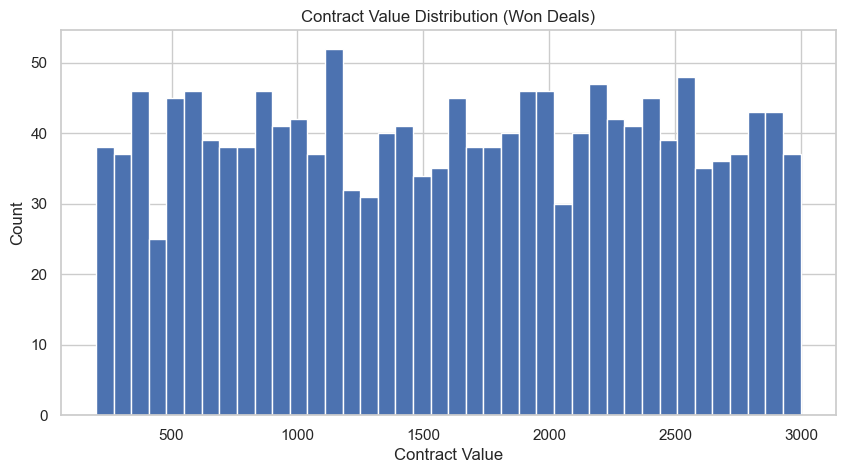

Lead            8000
Contract        1599
Active (Won)    1599
dtype: int64


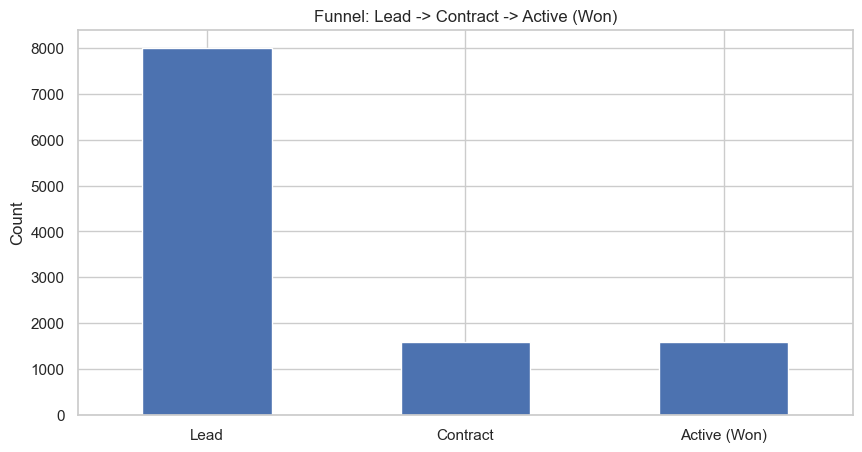

In [5]:
# Distribution and funnel
plt.figure()
plt.hist(df.loc[df["contract_value"] > 0, "contract_value"], bins=40)
plt.title("Contract Value Distribution (Won Deals)")
plt.xlabel("Contract Value")
plt.ylabel("Count")
plt.show()

# Funnel count
funnel = pd.Series({"Lead": len(df),
                    "Contract": (df["contract_value"] > 0).sum(),
                    "Active (Won)": (df["lead_stage"] == "Won").sum()})
print(funnel)
plt.figure()
funnel.plot(kind="bar")
plt.title("Funnel: Lead -> Contract -> Active (Won)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

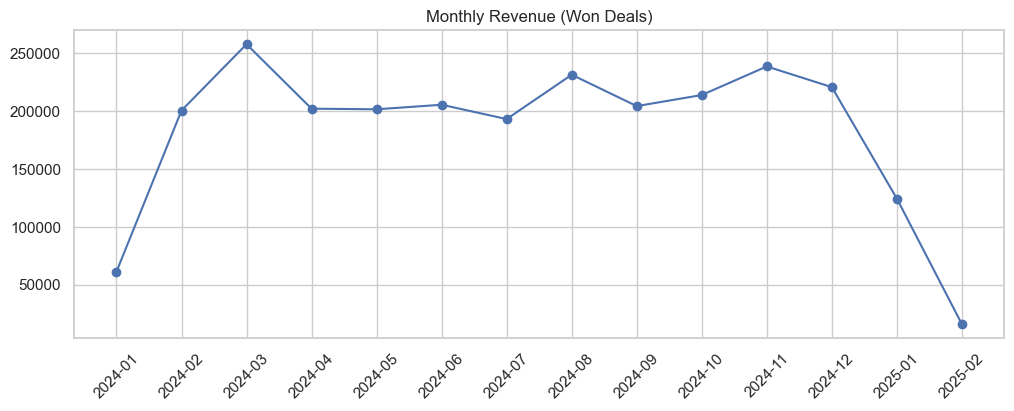

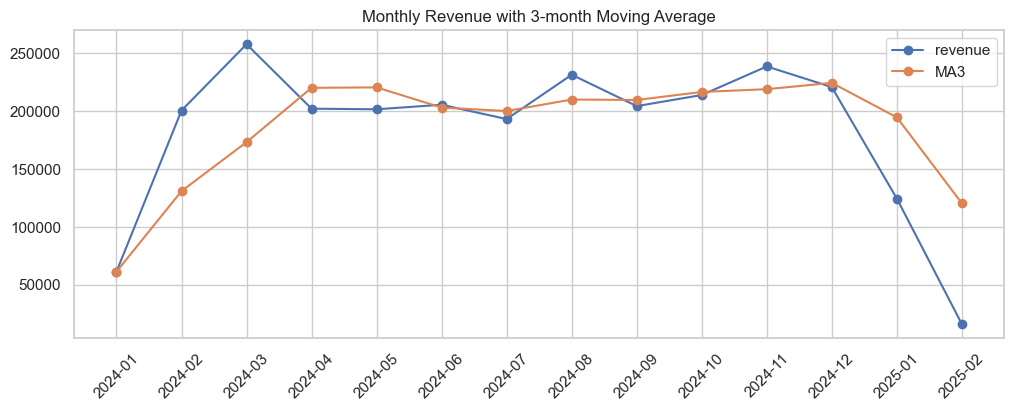

In [8]:
# Time-series: monthly revenue
# Derive year-month
df["year_month_contract"] = df["contract_date"].dt.to_period("M").astype(str)
monthly = df[df["contract_value"]>0].groupby("year_month_contract").agg(
    monthly_revenue=("contract_value", "sum"),
    monthly_contract=("lead_id", "count")
).reset_index().sort_values("year_month_contract")
monthly.head()

plt.figure(figsize=(12,4))
plt.plot(monthly["year_month_contract"], monthly["monthly_revenue"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue (Won Deals)")
plt.show()

# Rolling average
monthly["ma3"] = monthly["monthly_revenue"].rolling(3, min_periods=1).mean()
plt.figure(figsize=(12,4))
plt.plot(monthly["year_month_contract"], monthly["monthly_revenue"], marker="o", label="revenue")
plt.plot(monthly["year_month_contract"], monthly["ma3"], marker="o", label="MA3")
plt.xticks(rotation=45)
plt.legend()
plt.title("Monthly Revenue with 3-month Moving Average")
plt.show()


In [9]:
# Team & Sales rep performance
team_perf = df[df["contract_value"]>0].groupby("team").agg(
    revenue=("contract_value", "sum"),
    contract=("lead_id", "count"),
    avg_value=("contract_value", "mean")
).reset_index().sort_values("revenue", ascending=False)
team_perf

,team,revenue,contract,avg_value
3,Gamma,716664,443,1617.751693
2,Delta,625320,382,1636.963351
1,Beta,620864,377,1646.854111
0,Alpha,607829,397,1531.055416
